In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
working_dir = 'C:/Users/palmiteradmin/Documents/GitHub/MPNeuro/Ethovision/'
NUM_MICE = 3
import MPNeuro.plotting as MP_plot

In [29]:
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=3)

In [10]:
def load_rtpp_csv(csv_name):
    col_names = ['a', 'b', 'time', 'freq', 'hungry', 'mouse_id', 'distance', 'stim_time', 'other_time', 'middle_time', 'c']
    df = pd.read_csv(working_dir + csv_name, delimiter=';', encoding='utf-16', skiprows=3)
    df.columns = col_names
    df.drop(['a', 'b', 'c'], axis=1, inplace=True)
    return df

In [18]:
bin_min = 10 # ten minute bins
five_sated_df = load_rtpp_csv('160302 - RTPP - 5Hz sated.csv')
five_hungry_df = load_rtpp_csv('160304 - RTPP - 5Hz hungry.csv')
forty_sated_df = load_rtpp_csv('160307 - RTPP - 40Hz sated.csv')
five_sated_mean = five_sated_df.groupby('time').mean() / 60 / bin_min
five_sated_ste = five_sated_df.groupby('time').std() / 60 / bin_min / NUM_MICE
five_hungry_mean = five_hungry_df.groupby('time').mean() / 60 / bin_min
five_hungry_ste = five_hungry_df.groupby('time').std() / 60 / bin_min / NUM_MICE
forty_sated_mean = forty_sated_df.groupby('time').mean() / 60 / bin_min
forty_sated_ste = forty_sated_df.groupby('time').std() / 60 / bin_min / NUM_MICE

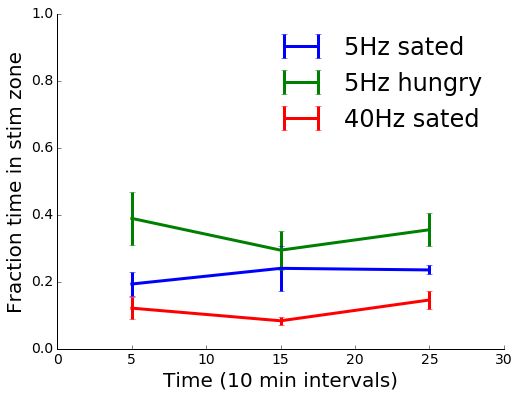

In [30]:
fig,ax = plt.subplots(1,1, figsize=[8,6])
x_indices = [5, 15, 25]
plt.errorbar(x_indices, five_sated_mean['stim_time'].values, five_sated_ste['stim_time'].values, label = '5Hz sated')
plt.errorbar(x_indices, five_hungry_mean['stim_time'].values, five_hungry_ste['stim_time'].values, label = '5Hz hungry')
plt.errorbar(x_indices, forty_sated_mean['stim_time'].values, forty_sated_ste['stim_time'].values, label = '40Hz sated')
plt.ylim([0, 1])
plt.xlim([0, 30])
plt.xlabel('Time (10 min intervals)')
plt.ylabel('Fraction time in stim zone')
plt.legend(frameon=False)
MP_plot.prettify_axes(ax)